In [97]:
# Import libraries required to do operations like convolution, gaussian blur, sobel operator, pixel manipulation, etc.
from PIL import Image
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path



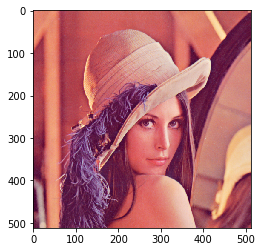

In [104]:
params = json.load(Path('./param.json').open())

# Load image into variable and display it
lena = Image.open("./test.png") # Paste address of image
# lena.show()

plt.imshow(lena, cmap = plt.get_cmap('gray'))
lena = np.asarray(lena)

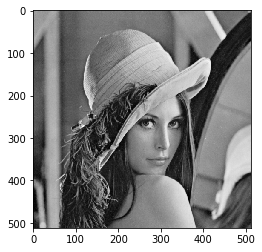

In [108]:
# Convert color image to grayscale to help extraction of edges and plot it
lena_gray = np.dot(lena[...,:3], [0.299, 0.587, 0.114])
#lion_gray = lion_gray.astype('int32')
plt.imshow(lena_gray, cmap = plt.get_cmap('gray'))


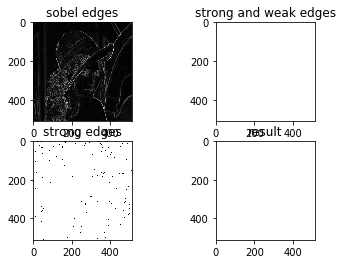

In [137]:
from skimage import filters
low = 0.01
high = 0.35
edges = filters.sobel(lena_gray)
lowt = (edges > low).astype('uint8')*255
hight = (edges > high).astype('uint8')*255
hyst = filters.apply_hysteresis_threshold(edges, low, high)

plt.figure()
plt.subplot(221)
plt.imshow(edges, cmap = plt.get_cmap('gray'))
plt.title('sobel edges')
plt.subplot(222)
plt.imshow(lowt, cmap=plt.cm.gray)
plt.title('strong and weak edges')
plt.subplot(223)
plt.imshow(hight, cmap = plt.get_cmap('gray'))
plt.title('strong edges')
plt.subplot(224)
plt.imshow(hyst, cmap = plt.get_cmap('gray'))
plt.title('result')
plt.show()

257392

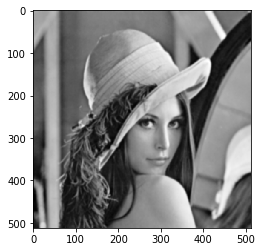

In [4]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
lena_gray_blurred = ndimage.gaussian_filter(lena_gray, sigma=1.4) # Note that the value of sigma is image specific so please tune it
plt.imshow(lena_gray_blurred, cmap = plt.get_cmap('gray'))

In [5]:
# Apply Sobel Filter using the convolution operation
# Note that in this case I have used the filter to have a maximum amgnitude of 2, but it can also be changed to other numbers for aggressive edge extraction
# For eg [-1,0,1], [-5,0,5], [-1,0,1]
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
        #Res = ndimage.convolve(img, Gx, mode='constant', cval=0.0)
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        #Res = ndimage.convolve(img, Gy, mode='constant', cval=0.0)
    
    return Res

In [6]:
# Normalize the pixel array, so that values are <= 1
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img

Image range from -0.736798 to 1.000000
The length of the range is 1.736798
Image range from -0.908069 to 1.000000
The length of the range is 1.908069


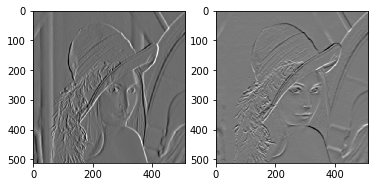

In [8]:
def print_statistic(gx):
    print('Image range from %f to %f' % (np.amin(gx), np.amax(gx)))
    print('The length of the range is %f' % np.ptp(gx))

# Apply Sobel Filter in X direction
gx = SobelFilter(lena_gray_blurred, 'x')
gx = Normalize(gx)
plt.subplot(121)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
print_statistic(gx)

# Apply Sobel Filter in Y direction
gy = SobelFilter(lena_gray_blurred, 'y')
gy = Normalize(gy)
plt.subplot(122)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
print_statistic(gy)

Image range from 0.000020 to 1.000000
The length of the range is 0.999980


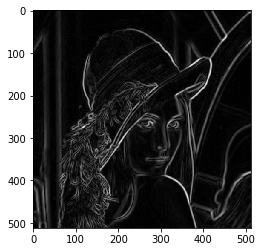

In [10]:
# Calculate the magnitude of the gradients obtained
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
print_statistic(Mag)

In [11]:
# Calculate direction of the gradients
Gradient = np.degrees(np.arctan2(gy,gx))

Image range from -179.999594 to 179.999273
The length of the range is 359.998868


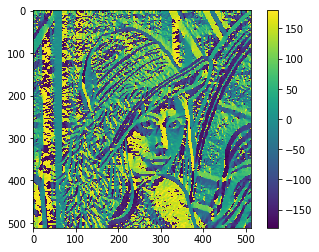

In [12]:
plt.imshow(Gradient)
plt.colorbar()
print_statistic(Gradient)

In [13]:
# Do Non Maximum Suppression with interpolation to get a better estimate of the magnitude values of the pixels in the gradient direction
# This is done to get thin edges
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS
                
            

In [14]:
# This is also non-maxima suppression but without interpolation i.e. the pixel closest to the gradient direction is used as the estimate
def NonMaxSupWithoutInterpol(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

Image range from 0.000000 to 1.000000
The length of the range is 1.000000


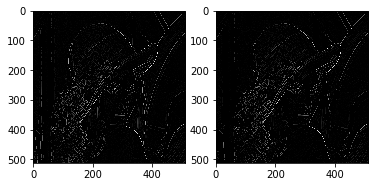

In [15]:
# Get the Non-Max Suppressed output
NMS = NonMaxSupWithInterpol(Mag, Gradient, gx, gy)
NMS_1 = NonMaxSupWithoutInterpol(Mag, Gradient)
NMS = Normalize(NMS)
NMS_1 = Normalize(NMS_1)
plt.subplot(121)
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(NMS_1, cmap = plt.get_cmap('gray'))
print_statistic(NMS_1)

In [16]:
NMS_image = Image.fromarray(np.uint8(NMS_1*255))
NMS_image.show()
NMS_image = Image.fromarray(np.uint8(NMS*255))
NMS_image.show()

In [17]:
# Double threshold Hysterisis
# Note that I have used a very slow iterative approach for ease of understanding, a faster implementation using recursion can be done instead
# This recursive approach would recurse through every strong edge and find all connected weak edges
def DoThreshHyst(img):
    highThresholdRatio = 0.2  
    lowThresholdRatio = 0.15 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
    
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                if(GSup[i,j] > highThreshold):
                    GSup[i,j] = 1
                elif(GSup[i,j] < lowThreshold):
                    GSup[i,j] = 0
                else:
                    if((GSup[i-1,j-1] > highThreshold) or 
                        (GSup[i-1,j] > highThreshold) or
                        (GSup[i-1,j+1] > highThreshold) or
                        (GSup[i,j-1] > highThreshold) or
                        (GSup[i,j+1] > highThreshold) or
                        (GSup[i+1,j-1] > highThreshold) or
                        (GSup[i+1,j] > highThreshold) or
                        (GSup[i+1,j+1] > highThreshold)):
                        GSup[i,j] = 1
        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup
                

In [18]:
highThresholdRatio = 0.2  
lowThresholdRatio = 0.15 
Img = np.copy(NMS_1)
h = int(Img.shape[0])
w = int(Img.shape[1])
highThreshold = np.max(Img) * highThresholdRatio
lowThreshold = highThreshold * lowThresholdRatio
print('highThreshold : %f' % highThreshold)
print('lowThreshold : %f' % lowThreshold)
G_h = (Img > highThreshold).astype('uint8')*255
G_l = (Img > lowThreshold).astype('uint8')*255
img_h = Image.fromarray(G_h)
img_l = Image.fromarray(G_l)
img_h.show() # strong edge
img_l.show() # strong and weak edge
Gmid = G_l - G_h
img_mid = Image.fromarray(Gmid)
img_mid.show() # weak edge

highThreshold : 0.200000
lowThreshold : 0.030000


In [87]:
G_new = np.copy(G_h)
num = 1
num_old = 0
while (num != num_old):
    for i in range(1,h-1):
        for j in range(1,w-1):
            if Gmid[i,j] == 255 and any(255 in e for e in G_new[i-1:i+2,j-1:j+2]):
                G_new[i,j] = 255
    num_old = num
    num = np.sum(G_new == 255)
    print(num)

10398
10767
11000
11174
11310
11419
11516
11589
11646
11702
11753
11789
11840
11873
11900
11930
11960
11985
12010
12024
12038
12048
12055
12061
12066
12071
12078
12094
12103
12110
12117
12123
12139
12143
12147
12149
12151
12153
12155
12157
12159
12161
12163
12166
12168
12169
12171
12173
12175
12179
12187
12194
12213
12221
12227
12231
12235
12239
12245
12251
12255
12260
12263
12267
12270
12283
12296
12303
12307
12311
12316
12320
12324
12326
12331
12335
12347
12350
12352
12357
12360
12361
12374
12375
12377
12384
12389
12394
12399
12403
12409
12414
12416
12419
12422
12426
12429
12432
12434
12437
12442
12442


In [91]:
img_final = Image.fromarray(G_new)
img_final.show()
img_h.show()

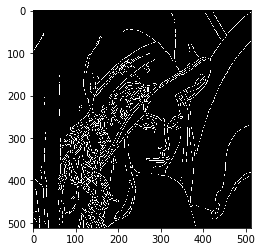

In [92]:
# The output of canny edge detection 
Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))


In [93]:
final_image = Image.fromarray(np.uint8(Final_Image*255))
final_image.show()

In [146]:
Path("./result").mkdir(exist_ok=True)